---
title: "Multivariate, probabilistic time-series forecasting with LSTM and Gaussian Copula"
author: "Sarem"
date: "2022-06-30"
categories: [Time Series, Neural Networks]
format:
  html:
    toc: true
    toc-location: left
    toc-depth: 2
    toc-title: Contents
description-meta: A quick Jupyter notebook about LSTMs and Copulas using tensorflow probability.
---

## Introduction

As commonly known, LSTMs ([Long short-term memory networks](https://de.wikipedia.org/wiki/Long_short-term_memory?ref=sarem-seitz.com)) are great for dealing with sequential data. One such example are multivariate time-series data. Here, LSTMs can model conditional distributions for complex forecasting problems.

For example, consider the following conditional forecasting distribution:
$$
\begin{gathered}
p\left(y_{t+1} \mid y_t\right)=\mathcal{N}\left(y_{t+1} \mid \mu_\theta\left(y_t\right), \Sigma_\theta\left(y_t\right)\right) \\
\mu_\theta\left(y_t\right)=f\left(y_t, h_t\right)_\mu \\
\Sigma_\theta\left(y_t\right)=L_\theta\left(y_t\right) L_\theta\left(y_t\right) \\
L_\theta\left(y_t\right)=f\left(y_t, h_t\right)_L
\end{gathered}
$$
- $f\left(y_t, h_t\right)_\mu:=$ LSTM mean output given hidden state $h_t$ 
- $f\left(y_t, h_t\right)_L:=$ LSTM covariance cholesky output given hidden state $h_t$

Notice that we predict the cholesky decomposition of the conditional covariance matrix. This ensures that the resulting covariance matrix is positive semi-definite. Now, this approach would allow us to model quite complex dynamical problems.

On the other hand, however, the degrees of freedom in this model will rapidly explode with increasing dimensionality D of the multivariate time-series. After all, we need (D^2+D)/2 LSTM outputs for the covariance structure alone. This can clearly lead to overfitting quite easily.

Another disadvantage is the assumption of a conditionally Gaussian time-series. As soon as our time-series is not a vector of real-numbers, this model does not work anymore.

Thus, a potential solution should satisfy two properties:

1. Allow to **parsimoniously** handle high-dimensional time-series
2. Work with conditionally **non-Gaussian** time-series

## LSTMs with Gaussian Copula
As a potential solution, we could separate the dependency among the time-series from their marginal distribution. Hence, let us presume constant conditional dependency between the time-series but varying conditional marginals. This indicates that a Copula model might be a good approach - for simplicity, we use a Gaussian Copula.

Since the basics of the Gaussian Copula have been discussed in [this previous article](https://sarem-seitz.com/blog/arma-forecasting-for-non-gaussian-time-series-data-using-copulas/?ref=sarem-seitz.com), we won't repeat them here.

In summary, our model looks as follows:
$$
p\left(y_{t+1} \mid y_t\right)=\prod_{d=1}^D p_d\left(y_{t+1}^{(d)} \mid \theta_d\left(y_t\right)\right) \cdot c\left(F\left(y_{t+1}^{(1)} \mid \theta_1\left(y_t\right)\right), \ldots, F\left(y_{t+1}^{(D)} \mid \theta_D\left(y_t\right)\right) ; R\right)
$$
- $p_d:=\mathrm{d}$-th marginal forecast density of $\mathrm{d}$-th time-series 
- $y_{t+1}^{(d)}$
- $\theta_d\left(y_t\right)=f\left(y_t ; h_t\right)_{\theta_d}:=\mathrm{d}$-th conditional parameter vector modelled as the output of the LSTM
- $c(\cdot, \ldots, \cdot ; R):=$ Gaussian Copula density with dependency parameter matrix $R$ 
- $F\left(y_{t+1}^{(d)} \mid \theta_d\left(y_t\right)\right):=$ d-th marginal forecast c.d.f.
This allows us to deal with arbitrary continuous marginal distributions. In fact, we could even work with  mixed continuous marginal distributions. In order to achieve sparsity in the copula parameter matrix, we could, for example, add a regularization term as is [typically done](https://scikit-learn.org/stable/modules/covariance.html?ref=sarem-seitz.com#shrunk-covariance) when estimating high-dimensional covariance matrices.

The only drawback now is the assumption of a constant dependency over time. If this contradicts the data at hand, we might need to model the copula parameter in an auto-regressive manner as well. A low-rank matrix approach could preserve some parsimony then.

To show how this could be implemented in the case of Gaussian marginals, I have created a quick Jupyter notebook with tensorflow. Regarding the Copula part, the [tensorflow example on Gaussian Copulas](https://www.tensorflow.org/probability/examples/Gaussian_Copula?ref=sarem-seitz.com) has a ready-made implementation using [tensorflow probability bijectors](https://www.tensorflow.org/probability/api_docs/python/tfp/bijectors/Bijector?ref=sarem-seitz.com).

## Implementation (sketch, not too much explanations from here on)
Data taken from https://www.kaggle.com/datasets/vagifa/usa-commodity-prices. We will use only culinary oil price, presuming that there is some underlying correlation among them.

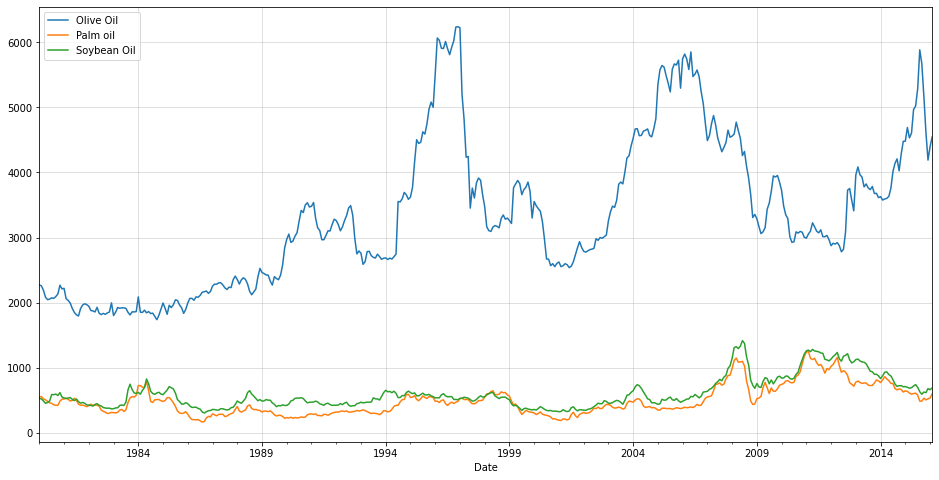

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("../data/commodity-prices-2016.csv")
df = df.set_index("Date")
df.index = pd.to_datetime(df.index)

oils = df[["Olive Oil","Palm oil","Soybean Oil"]]

oils.plot(figsize=(16,8))
plt.grid(alpha=0.5)

#### Use log-difference prices for standardization 
(i.e. 'log-returns')

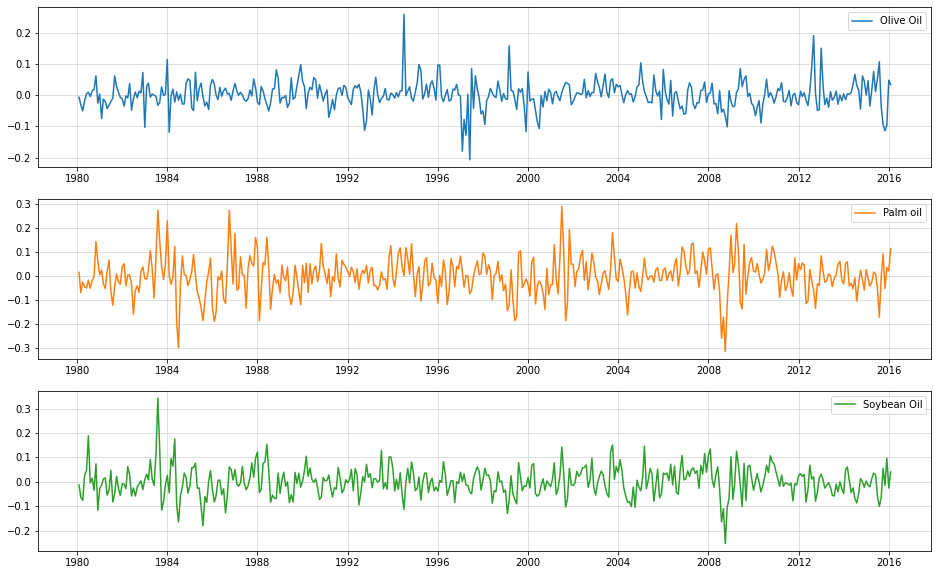

In [2]:
import numpy as np

oils_ld = np.log(oils).diff().iloc[1:,:]

fig, ax = plt.subplots(3,1, figsize = (16,10))
ax[0].plot(oils_ld["Olive Oil"],label="Olive Oil",color="C0")
ax[1].plot(oils_ld["Palm oil"], label="Palm oil",color="C1")
ax[2].plot(oils_ld["Soybean Oil"], label="Soybean Oil",color="C2")
[a.grid(alpha=0.5) for a in ax]
[a.legend() for a in ax]

#### Create lag-1 features as input 
We might want to go to higher lags for increased accuracy.

In [3]:
oils_lagged = pd.concat([oils_ld.shift(1),oils_ld],1).iloc[1:,:]
oils_lagged.columns = [c+"_l1" for c in oils_ld.columns] + list(oils_ld.columns)
oils_lagged

/var/folders/2d/hl2cr85d2pb2kfbmsng3267c0000gn/T/ipykernel_61976/3710246824.py:1: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  oils_lagged = pd.concat([oils_ld.shift(1),oils_ld],1).iloc[1:,:]


,Olive Oil_l1,Palm oil_l1,Soybean Oil_l1,Olive Oil,Palm oil,Soybean Oil
Date,,,,,,
1980-03-01,-0.006731,0.014993,-0.013089,-0.030768,-0.069312,-0.063604
1980-04-01,-0.030768,-0.069312,-0.063604,-0.050111,-0.025850,-0.076200
1980-05-01,-0.050111,-0.025850,-0.076200,-0.017756,-0.045196,0.026527
1980-06-01,-0.017756,-0.045196,0.026527,0.004272,-0.050933,0.046044
1980-07-01,0.004272,-0.050933,0.046044,0.009627,-0.018182,0.189117
...,...,...,...,...,...,...
2015-10-01,-0.036858,-0.002459,-0.063183,-0.092682,0.092317,0.055295
2015-11-01,-0.092682,0.092317,0.055295,-0.114045,-0.052427,-0.014648
2015-12-01,-0.114045,-0.052427,-0.014648,-0.096288,0.034072,0.096772


In [4]:
X_train = oils_lagged.iloc[:-12,:3].values
y_train = oils_lagged.iloc[:-12,3:].values
X_test = oils_lagged.iloc[-12:,:3].values
y_test = oils_lagged.iloc[-12:,3:].values

#### Create the model (https://www.tensorflow.org/probability/examples/Gaussian_Copula#:~:text=Gaussian-,Copula,-To%20illustrate%20how)

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

class GaussianCopulaTriL(tfd.TransformedDistribution):
    def __init__(self, loc, scale_tril):
        super(GaussianCopulaTriL, self).__init__(
            distribution=tfd.MultivariateNormalTriL(
                loc=loc,
                scale_tril=scale_tril),
            bijector=tfb.NormalCDF(),
            validate_args=True,
            name="GaussianCopulaTriLUniform")

        
class CopulaLSTMModel(tf.keras.Model):
    
    def __init__(self, input_dims=3, output_dims=3):
        super().__init__()
        self.input_dims = input_dims
        self.output_dims = output_dims
        
        #use LSTM state to ease training and testing state transition
        self.c0 = tf.Variable(tf.ones([1,input_dims]), trainable = True) 
        self.h0 = tf.Variable(tf.ones([1,input_dims]), trainable = True)
        
        self.lstm = layers.LSTM(input_dims, 
                                         batch_size=(1,1,input_dims),
                                         return_sequences=True,
                                         return_state=True
                                        )
        
        self.mean_layer = layers.Dense(output_dims)
        self.std_layer = layers.Dense(output_dims,activation=tf.nn.softplus)
        
        self.chol = tf.Variable(tf.random.normal((output_dims,output_dims)), trainable = True)
    
    
    def call(self, inputs):
        lstm_out = self.lstm(inputs, initial_state = [self.c0, self.h0])[0]
        means = self.mean_layer(lstm_out)
        stds = self.std_layer(lstm_out)
        
        distributions = tfd.Normal(means, stds)
        
        return distributions
    
    
    def call_with_state(self, inputs, c_state, h_state):
        #explicitly use and return the initial state - primarily for forecasting
        lstm_out, c_out, h_out = self.lstm(inputs, initial_state = [c_state, h_state])
        
        
        means = self.mean_layer(lstm_out)
        stds = self.std_layer(lstm_out)
        
        distributions = tfd.Normal(means, stds)
        
        return distributions, c_out, h_out
        
    
    def get_normalized_covariance(self):
        unnormalized_covariance = self.chol@tf.transpose(self.chol)
        normalizer = tf.eye(self.output_dims) * 1./(tf.linalg.tensor_diag_part(unnormalized_covariance)**0.5)
        
        return normalizer@unnormalized_covariance@normalizer
        
        
    
    def conditional_log_prob(self, inputs, targets):
        marginals = self.call(inputs)
        marginal_lpdfs = tf.reshape(marginals.log_prob(targets),(-1,self.output_dims))
        
        copula_transformed = marginals.cdf(y_train)
        normalized_covariance = self.get_normalized_covariance()  #need covariance matrix with unit diagonal for Gaussian Copula
        copula_dist = GaussianCopulaTriL(loc=tf.zeros(self.output_dims),scale_tril = tf.linalg.cholesky(normalized_covariance))
        
        copula_lpdfs = copula_dist.log_prob(copula_transformed)
        
        return tf.reduce_mean(tf.math.reduce_sum(marginal_lpdfs,1) + copula_lpdfs)
        
    
    def train_step(self, data):
        #custom training steps due to custom loglikelihood-loss
        x, y = data
        
        with tf.GradientTape() as tape:
            loss = -self.conditional_log_prob(x,y)
            
        trainable_vars = self.trainable_weights + self.lstm.trainable_weights + self.mean_layer.trainable_weights + self.std_layer.trainable_weights
        gradients = tape.gradient(loss, trainable_vars)
        
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        
        return {"Current loss": loss}
    
    
    
    def sample_forecast(self, X_train, y_train, forecast_periods = 12):
        #this is still quite slow; should be optimized if used for a real-world problem
        
        normalized_covariance = self.get_normalized_covariance()
        copula_dist = tfp.distributions.MultivariateNormalTriL(scale_tril = tf.linalg.cholesky(normalized_covariance))
        copula_sample = tfp.distributions.Normal(0,1).cdf(copula_dist.sample(forecast_periods))
        
        sample = []
        
        input_current = y_train
        
        for t in range(forecast_periods):
        
            _, c_current, h_current = self.lstm(X_train)

            new_dist, c_current, h_current = self.call_with_state(tf.reshape(input_current,(1,1,self.input_dims)), c_current, h_current)

            input_current = new_dist.quantile(tf.reshape(copula_sample[t,:],(1,1,self.output_dims)))
            sample.append(tf.reshape(input_current,(1,self.output_dims)).numpy().reshape(1,self.output_dims))
        
        return np.concatenate(sample)

#### Train the model

In [6]:
np.random.seed(123)
tf.random.set_seed(123)

test = CopulaLSTMModel()

test.compile(optimizer="adam")

test.fit(X_train.reshape(1,-1,3),y_train.reshape(1,-1,3), epochs = 250, verbose=0) #relatively fast

#### Raw log-diff predictions

In [ ]:
np.random.seed(123)
tf.random.set_seed(123)

samples = [test.sample_forecast(X_train.reshape(1,-1,3),y_train[-1,:].reshape(1,1,3)) for _ in range(500)] #very slow, grab a coffee or two

samples_restructured = [np.concatenate(list(map(lambda x: x[:,i].reshape(-1,1),samples)),1) for i in range(3)]
means = [np.mean(s,1) for s in samples_restructured]
lowers = [np.quantile(s,0.05,1) for s in samples_restructured]
uppers = [np.quantile(s,0.95,1) for s in samples_restructured]

fig, ax = plt.subplots(3,1, figsize = (16,10))
[ax[i].plot(y_test[:,i],label=oils.columns[i],color="C{}".format(i)) for i in range(3)]
[ax[i].plot(means[i], label = "Mean forecast", color = "red") for i in range(3)]
[ax[i].fill_between(np.arange(len(y_test)),lowers[i],uppers[i], label = "Forecast interval", color="red", alpha=0.2) for i in range(3)]

[a.grid(alpha=0.5) for a in ax]

#### Actual price predictions

In [ ]:
samples_retrans = [np.exp(np.log(oils.iloc[-13,i+3])+np.cumsum(samples_restructured[i],0)) for i in range(3)]
means_retrans = [np.mean(s,1) for s in samples_retrans]
lowers_retrans = [np.quantile(s,0.025,1) for s in samples_retrans]
uppers_retrans = [np.quantile(s,0.975,1) for s in samples_retrans]

fig, ax = plt.subplots(3,1, figsize = (16,10))
[ax[i].plot(oils.values[:,i],label=oils.columns[i],color="C{}".format(i)) for i in range(3)]
[ax[i].set_xlim((1,len(oils))) for i in range(3)]
[ax[i].plot(np.arange(len(oils)-13,len(oils)),np.concatenate([[oils.iloc[-13,i]],means_retrans[i]]), label = "Mean forecast", color = "purple") for i in range(3)]
[ax[i].fill_between(np.arange(len(oils)-13,len(oils)),np.concatenate([[oils.iloc[-13,i]],lowers_retrans[i]]),np.concatenate([[oils.iloc[-13,i]],uppers_retrans[i]]), label = "Forecast interval", color="purple", alpha=0.2) for i in range(3)]

[a.grid(alpha=0.5) for a in ax]

#### Sample trajectories

In [ ]:
fig, ax = plt.subplots(3,1, figsize = (16,10))
for s in range(500):
    [ax[i].plot(np.arange(len(oils)-13,len(oils)),np.concatenate([[oils.iloc[-13,i+3]],samples_retrans[i][:,s]]), label = "Mean forecast", color = "purple", lw=0.1) for i in range(3)]
[ax[i].plot(oils.values[:,i],label=oils.columns[i],color="C{}".format(i), lw=5) for i in range(3)]
[ax[i].set_xlim((375,len(oils))) for i in range(3)]

[a.grid(alpha=0.5) for a in ax]

## Conclusion
This was just a rough collection of ideas on how a Copula-LSTM time-series model could look like. Feel free to contact me for more information.

## References 
**[1]** Hochreiter, Sepp; Schmidhuber, Jürgen. Long short-term memory. Neural computation, 1997, 9.8, p. 1735-1780.

**[2]** Nelsen, Roger B. An introduction to copulas. Springer Science & Business Media, 2007.